# Purpose:
Gather data from existing CheckUser logs.[T245226](https://phabricator.wikimedia.org/T245226)


# Data timeframe:
2019.1.1~2020.3.5 on enwiki


# Summary:
- How often did someone search for IP ranges versus just IPs?<br >

| checkip_type|	num_checks|
| ---------------| -------------|
| check_IPonly	| 23926|
| check_IPrange| 21517|

- How often did the XFF feature get used?<br >
__12 out of 45443__

- How often did usernames get looked up versus IPs?<br >

| check_type	|num_checks|
| --------------| -----------|
| check_ip	|45450|
| check_user|27366|

- How many lookups per case? <br >
__Current cu_log did not log event on a case base. I estimate the user intention based on date. Assuming for a regular user, all lookups on the same day are for one intention.__ 
__After exclude some heavy users, a common user loops up 2.89 times intention in average.__



In [9]:
import pandas as pd
from wmfdata import mariadb

In [10]:
import wmfdata
wmfdata.utils.insert_code_toggle()

In [3]:
#old user behavior is less strict with inputing check user reason, so focus the data since 2019.
checkuser_count_query = '''
SELECT cul_reason, substr(cul_timestamp, 1,8) AS date, COUNT(cul_id) AS checkuser_count 
FROM cu_log 
WHERE substr(cul_timestamp,1,4) >= 2019 
GROUP BY cul_reason, date  
ORDER BY checkuser_count DESC,date 

'''

In [4]:
df_checkuser_2019_enwiki=mariadb.run(checkuser_count_query, 'enwiki')

In [5]:
df_checkuser_2019_enwiki.head(10)

,cul_reason,date,checkuser_count
0,suspicious new user,20190328,71
1,spambot,20200213,56
2,spambot,20190217,47
3,suspicious new user,20190823,43
4,Chinese spambot,20190328,36
5,"suspicious newish user, CSD, UPE",20200120,36
6,suspicious newish user,20191128,35
7,suspicious new user,20190902,34
8,sock check,20190102,33
9,spambot,20190414,33


In [6]:
df_checkuser_2019_enwiki.describe()

,checkuser_count
count,24464.000000
mean,2.957448
std,2.751807
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,71.000000


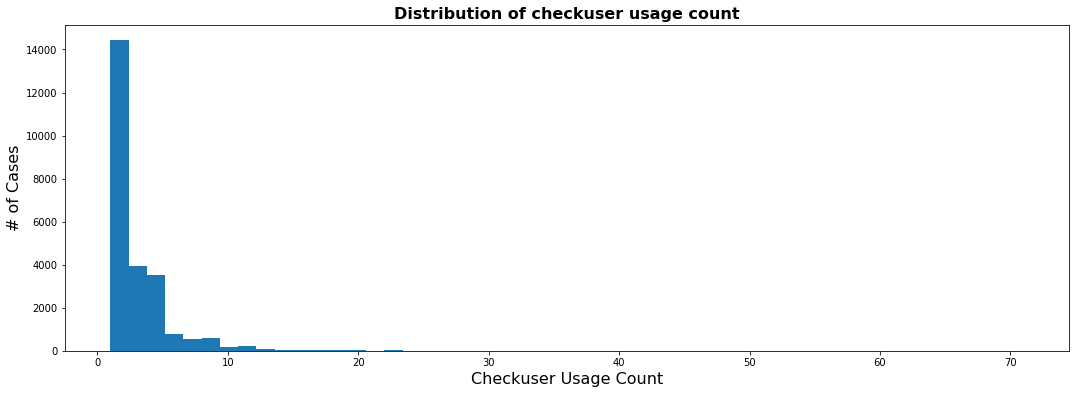

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.hist(df_checkuser_2019_enwiki['checkuser_count'], bins=50, histtype='bar')
plt.title('Distribution of checkuser usage count',fontweight="bold",fontsize = 16)
plt.ylabel('# of Cases',fontsize = 16)
plt.xlabel('Checkuser Usage Count',fontsize = 16)
plt.show()

Look at the heavy users who checked users more than 20 times a day, they tend to belong to below user groups: bot, checkuser, sysops, abusefilter, admin, etc. In order to get the sense of the common users behavior, I cut off the right tail and exclude "checkuser usage count > 20" when calculate the average of usage per intention.

In [8]:
df_checkuser_2019_enwiki[df_checkuser_2019_enwiki['checkuser_count']<=20].describe()

,checkuser_count
count,24399.000000
mean,2.892086
std,2.408051
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,20.000000


__For common users, the estimated average checks per intention is 2.89__

### How often did someone search for IP ranges versus just IPs?

There are 6 types of checkuser in cu_log table


| cul_type    |
| ------------|
| ipedits     |
| ipedits-xff |
| ipusers     |
| ipusers-xff |
| useredits   |
| userips     |

All searching IP events includes 4 types: ipedits,ipedits-xff,ipusers,ipusers-xff.

In [15]:
checkip_count_query = '''
SELECT tmp.checkip_type, COUNT(1) AS num_checks 
FROM (
SELECT cul_id, 
    (CASE WHEN cul_range_start='' THEN 'check_IP' ELSE 'check_IPrange' END) AS checkip_type   
    FROM cu_log 
    WHERE  cul_type IN ( 'ipusers-xff','ipusers','ipedits-xff','ipedits') 
    AND  substr(cul_timestamp,1,4) >= 2019 ) AS tmp 
GROUP BY tmp.checkip_type;
'''

In [21]:
df_checkip_vs_iprange_2019_enwiki=mariadb.run(checkip_count_query, 'enwiki')

In [22]:
df_checkip_vs_iprange_2019_enwiki

,checkip_type,num_checks
0,check_IP,23926
1,check_IPrange,21517


### How often did the XFF feature get used?

In [ ]:
checkip_all_count_query = '''

SELECT COUNT(1) AS num_all_check_ips
    FROM cu_log 
    WHERE  cul_type IN ( 'ipusers-xff','ipusers','ipedits-xff','ipedits') 
    AND  substr(cul_timestamp,1,4) >= 2019  

'''

In [ ]:
all_checkip_2019_enwiki=mariadb.run(checkip_all_count_query, 'enwiki')

In [ ]:
all_checkip_2019_enwiki

In [34]:
check_xff_count_query = '''
SELECT COUNT(1) AS num_check_xff
    FROM cu_log 
    WHERE  cul_type IN ('ipusers-xff', 'ipedits-xff') 
    AND  substr(cul_timestamp,1,4) >= 2019  
'''

In [35]:
df_check_xff_enwiki=mariadb.run(check_xff_count_query, 'enwiki')

In [36]:
df_check_xff_enwiki

,num_check_xff
0,12


### How often did usernames get looked up versus IPs?

In [47]:
check_ip_vs_user_query = '''
SELECT tmp.check_type, COUNT(1) AS num_checks 
FROM (
SELECT cul_id, 
    (CASE WHEN cul_type IN ( 'ipusers-xff','ipusers','ipedits-xff','ipedits')  THEN 'check_ip'  WHEN cul_type IN ('useredits','userips')  THEN 'check_user' ELSE 'none' END) AS check_type   
    FROM cu_log 
    WHERE   substr(cul_timestamp,1,4) >= 2019 ) AS tmp 
GROUP BY tmp.check_type;
'''

In [48]:
df_check_ip_vs_user_enwiki=mariadb.run(check_ip_vs_user_query, 'enwiki')

In [49]:
df_check_ip_vs_user_enwiki

,check_type,num_checks
0,check_ip,45450
1,check_user,27366
